In [1]:
import csv
import numpy as np
import matrixFactorization as mf
import biasMatrixFactorization as bmf
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from basicVisualization import getPopularMovies, getBestMovies, getThreeGenres, basicVisualization
from projection import projection

BORDER = "==================================================================="


In [2]:

def loadRatings(fileName):
    '''
    Load data from the data.txt file

    Input format: user_id\tmovie_id\trating

    user_id = int
    movie_id = int
    rating = int
    '''
    ratings = []
    f = open(fileName, 'r')

    for line in f:
        ratings.append(line.split())

    return np.asarray(ratings, dtype=int)


def loadMovies(fileName):
    '''
    Load data from the movies.txt file

    Input format: movie_id\tmovie_title\tUnknown\tAction\tAdventure\tAnimation
    \tChildrens\tComedy\tCrime\tDocumentary\tDrama\tFantasy\tFilm-Noir\tHorror
    \tMusical\tMystery\tRomance\tSci-Fi\tThriller\tWar\tWestern

    movie_id = int
    movie_title = string
    {Unknown, Action,..., Western} = bool (0 or 1)

    returns three dictionaries
    movie_ID = {movie_id:movie_title}
    movie_categoty = {movie_id:categories}
        where categories is a numpy array of 0 or 1 representing if the
        movie falls under the category
    movie_genres = {index of genre: genre name}
    '''
    movie_ID = {}
    movie_category = {}

    movie_genres = {
        0:  'Unknown',   1:  'Action',  2:  'Adventure', 3: 'Animation',
        4:  'Childrens', 5:  'Comedy',  6:  'Crime',     7: 'Documentary',
        8:  'Drama',     9:  'Fantasy', 10: 'Film-Noir', 11: 'Horror',
        12: 'Musical',   13: 'Mystery', 14: 'Romance',   15: 'Sci-Fi',
        16: 'Thriller',  17: 'War',     18: 'Western'}

    with open(fileName, encoding='ISO-8859-1') as f:
        reader = csv.reader(f, delimiter='\t')
        for movieData in reader:
            # print(movieData)
            movie_ID[int(movieData[0])] = movieData[1]
            categories = [int(x) for x in movieData[2:]]
            movie_category[int(movieData[0])] = np.asarray(categories)

    return movie_ID, movie_category, movie_genres


def Homework_5_SVD_With_Regularization(train, test):
    print(BORDER)
    print("Homework_5_SVD_With_Regularization - reg")
    M = max(max(train[:, 0]), max(test[:, 0])).astype(int)  # users
    N = max(max(train[:, 1]), max(test[:, 1])).astype(int)  # movies
    print("Factorizing with ", M, " users, ", N, " movies.")
    K = 20

    regs = [10**-4, 10**-3, 10**-2, 10**-1, 1]
    eta = 0.03  # learning rate
    E_ins = []
    E_outs = []

    for reg in regs:
        print("Training model with reg = %s" % (reg))
        U, V, _ = mf.train_model(M, N, K, eta, reg, train)
        E_ins.append(mf.get_err(U, V, train))
        E_outs.append(mf.get_err(U, V, test))

    plt.plot(regs, E_ins, label='$E_{in}$')
    plt.plot(regs, E_outs, label='$E_{out}$')
    plt.title('Error vs. reg')
    plt.xlabel('reg')
    plt.ylabel('Error')
    plt.xscale('log')
    plt.legend()
    plt.savefig('visualizations/method1_reg.png')
    plt.clf()


def Homework_5_SVD(train, test):
    print(BORDER)
    print("Homework_5_SVD")
    M = max(max(train[:, 0]), max(test[:, 0])).astype(int)  # users
    N = max(max(train[:, 1]), max(test[:, 1])).astype(int)  # movies
    print("Factorizing with ", M, " users, ", N, " movies.")
    K = 20

    reg = 10**-1
    eta = 0.03  # learning rate
    U, V, _ = mf.train_model(M, N, K, eta, reg, train)
    E_in = mf.get_err(U, V, train)
    E_out = mf.get_err(U, V, test)
    print("E_in = ", E_in)
    print("E_out = ", E_out)

    return U, V


def SVD_With_Bias(train, test):
    print(BORDER)
    print("SVD_With_Bias")
    M = max(max(train[:, 0]), max(test[:, 0])).astype(int)  # users
    N = max(max(train[:, 1]), max(test[:, 1])).astype(int)  # movies
    print("Factorizing with ", M, " users, ", N, " movies.")
    K = 20

    reg = 10**-1
    eta = 0.03  # learning rate
    U, V, err, a, b, mu = bmf.train_model(M, N, K, eta, reg, train)
    E_in = bmf.get_err(U, V, train, a, b, mu, reg)
    E_out = bmf.get_err(U, V, test, a, b, mu, reg)
    print("E_in = ", E_in)
    print("E_out = ", E_out)

    return U, V


def Get_Err_From_Pred(pred, ratings):
    n_rows = ratings.shape[0]
    error = 0

    for row in range(n_rows):
        user_ind = ratings[row, 0] - 1
        movie_ind = ratings[row, 1] - 1
        rating = ratings[row, 2]
        dev = rating - pred[user_ind, movie_ind]
        error += dev * dev
    return ((1 / 2.) * error) / n_rows


def Off_The_Shelf_SVD(train, test):
    print(BORDER)
    print("Off_The_Shelf_SVD")
    M = max(max(train[:, 0]), max(test[:, 0])).astype(int)  # users
    N = max(max(train[:, 1]), max(test[:, 1])).astype(int)  # movies

    train_matrix = np.zeros((M, N))
    n_rows = train.shape[0]
    for row in range(n_rows):
        user_ind = train[row, 0] - 1
        movie_ind = train[row, 1] - 1
        train_matrix[user_ind, movie_ind] = train[row, 2]
    U, s, Vt = svds(train_matrix, k=20)
    s_diag_matrix = np.diag(s)
    pred = np.dot(np.dot(U, s_diag_matrix), Vt)
    E_in = Get_Err_From_Pred(pred, train)
    E_out = Get_Err_From_Pred(pred, test)
    print("E_in = ", E_in)
    print("E_out = ", E_out)

    return U, Vt.transpose()


In [3]:
directory = 'visualizations/'
dataFile = "data/data.txt"
moviesFile = "data/movies.txt"
trainingFile = "data/train.txt"
testFile = "data/test.txt"

# all movie ratings as movie_ratings = [[user ID, movie ID, rating]]
movie_ratings = loadRatings(dataFile)
# movie info as three dictionaries:
#     movie_ID = {movie_id:movie_title}
#     movie_category = {movie_id:categories}
#     movie_genres = {index of genre: genre name}
movie_ID, movie_category, movie_genres = loadMovies(moviesFile)

train = loadRatings(trainingFile)
test  = loadRatings(testFile)


In [4]:
basicVisualization(movie_ratings, movie_ID, movie_category, movie_genres,
                   directory)

In [5]:
Homework_5_SVD_With_Regularization(train, test)

Homework_5_SVD_With_Regularization - reg
Factorizing with  943  users,  1682  movies.
Training model with reg = 0.0001
epoch: 0, error: 1.069092
epoch: 1, error: 0.811282
epoch: 2, error: 0.721082
epoch: 3, error: 0.662035
epoch: 4, error: 0.636547
epoch: 5, error: 0.601487
epoch: 6, error: 0.575964
epoch: 7, error: 0.569331
epoch: 8, error: 0.545007
epoch: 9, error: 0.537173
epoch: 10, error: 0.528371
epoch: 11, error: 0.514696
epoch: 12, error: 0.519640
epoch: 13, error: 0.520166
Training model with reg = 0.001
epoch: 0, error: 1.070087
epoch: 1, error: 0.810876
epoch: 2, error: 0.720341
epoch: 3, error: 0.663534
epoch: 4, error: 0.636130
epoch: 5, error: 0.601237
epoch: 6, error: 0.574896
epoch: 7, error: 0.561719
epoch: 8, error: 0.545753
epoch: 9, error: 0.534716
epoch: 10, error: 0.526161
epoch: 11, error: 0.522376
epoch: 12, error: 0.509121
epoch: 13, error: 0.504525
epoch: 14, error: 0.499317
epoch: 15, error: 0.496152
epoch: 16, error: 0.489700
epoch: 17, error: 0.495122
epoch

In [5]:
U, V = Homework_5_SVD(train, test)
U_proj, V_proj = projection(U, V)



Homework_5_SVD
Factorizing with  943  users,  1682  movies.
epoch: 0, error: 1.017403
epoch: 1, error: 0.856757
epoch: 2, error: 0.799482
epoch: 3, error: 0.772177
epoch: 4, error: 0.753033
epoch: 5, error: 0.717017
epoch: 6, error: 0.709736
epoch: 7, error: 0.692718
epoch: 8, error: 0.679273
epoch: 9, error: 0.672129
epoch: 10, error: 0.655094
epoch: 11, error: 0.640884
epoch: 12, error: 0.633501
epoch: 13, error: 0.625148
epoch: 14, error: 0.621973
epoch: 15, error: 0.614219
epoch: 16, error: 0.606523
epoch: 17, error: 0.613415
epoch: 18, error: 0.601592
epoch: 19, error: 0.596785
epoch: 20, error: 0.589639
epoch: 21, error: 0.586166
epoch: 22, error: 0.583621
epoch: 23, error: 0.581700
epoch: 24, error: 0.575611
epoch: 25, error: 0.573563
epoch: 26, error: 0.574855
epoch: 27, error: 0.577127
epoch: 28, error: 0.572793
epoch: 29, error: 0.568704
epoch: 30, error: 0.566225
epoch: 31, error: 0.568597
epoch: 32, error: 0.567839
E_in =  0.561440787223
E_out =  0.882153891512


In [6]:
def PlotMovies(V0, V1, titles, plotTitle, showTitles=True):
    plt.scatter(V0, V1)

    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)

    if (showTitles):
        for title, x, y in zip(titles, V0, V1):
            plt.annotate(
                title,
                xy=(x, y), xytext=(0, 20),
                textcoords='offset points', ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    plt.show()

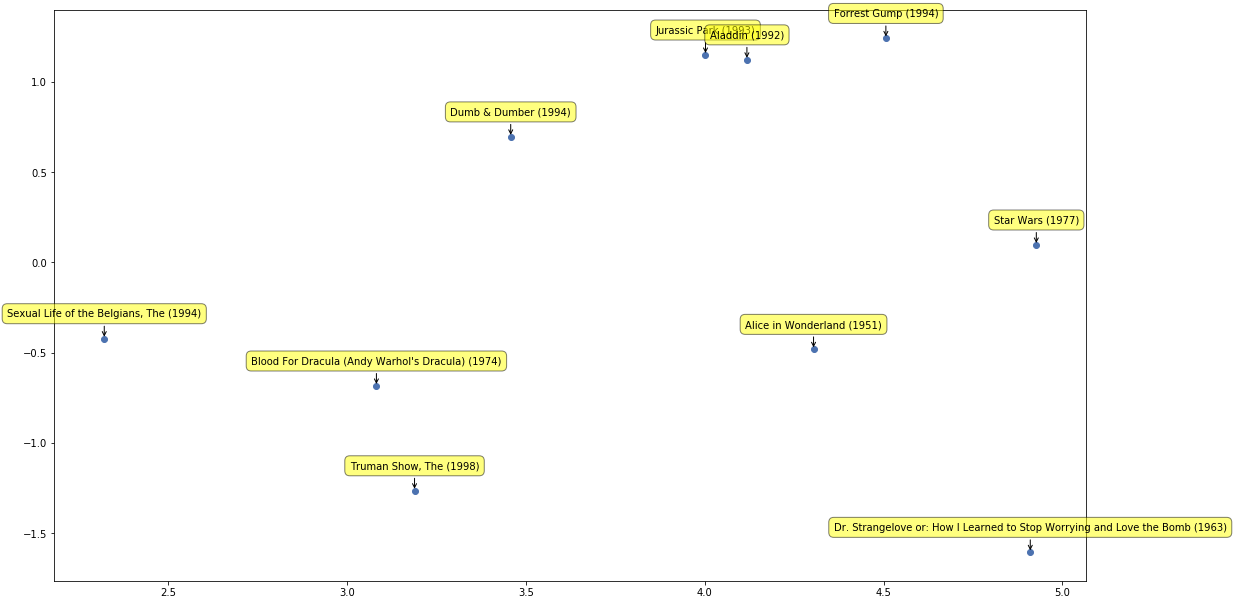

In [8]:
#===============================================================================================
# Visualize V for any ten movies of your choice from the MovieLens dataset.
# Let's choose the first 10, because I'm lazy
#===============================================================================================
movieIndices = [
    50,   # Star Wars
    69,   # Forrest Gump
    82,   # Jurassic Park
    95,   # Aladdin
    420,  # Alice in Wonderland
    474,  # Dr. Strangelove
    666,  # Blood for Dracula
    780,  # Dumb and Dumber
    1127, # The Truman Show
    1360, # Sexual Life of the Belgians
]

V0 = []
V1 = []
titles = []
for i in movieIndices:
    V0.append(V_proj[0, i - 1])
    V1.append(V_proj[1, i - 1])
    titles.append(movie_ID[i])

PlotMovies(V0, V1, titles, "")


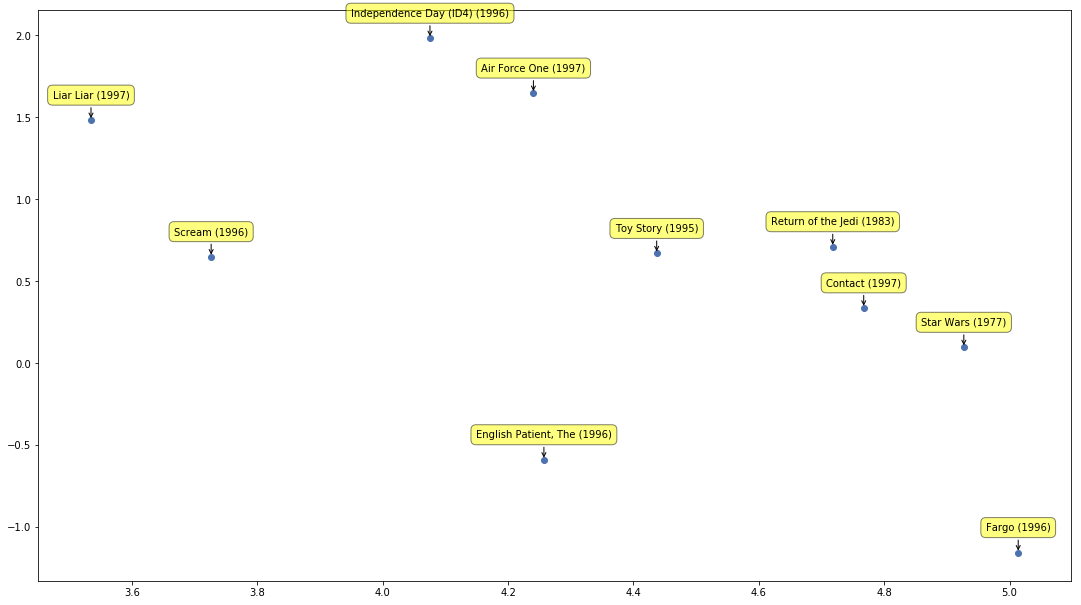

In [9]:
#===============================================================================================
# Visualize V for the ten most popular movies (movies which have received the most ratings).
#===============================================================================================
top10 = getPopularMovies(movie_ratings, movie_ID)

V0 = []
V1 = []
titles = []
for i, _ in top10:
    V0.append(V_proj[0, i - 1])
    V1.append(V_proj[1, i - 1])
    titles.append(movie_ID[i])
    

PlotMovies(V0, V1, titles, "")

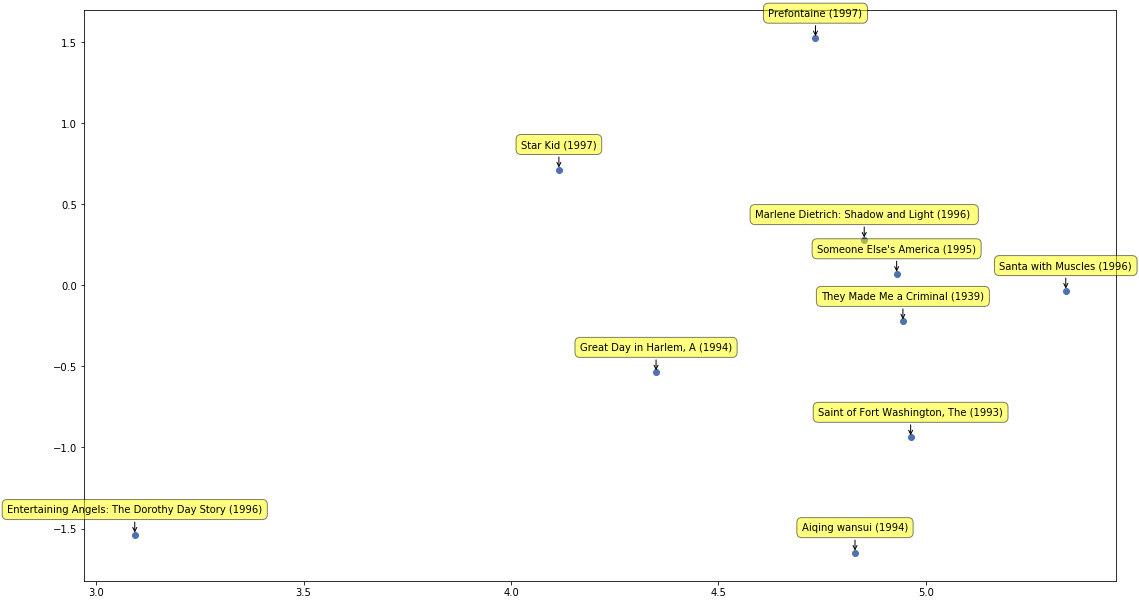

In [10]:
#===============================================================================================
# Visualize V for the ten best movies (movies with the highest average ratings).
#===============================================================================================
best10 = getBestMovies(movie_ratings)

V0 = []
V1 = []
titles = []
for i in best10:
    V0.append(V_proj[0, i - 1])
    V1.append(V_proj[1, i - 1])
    titles.append(movie_ID[i])
    

PlotMovies(V0, V1, titles, "")


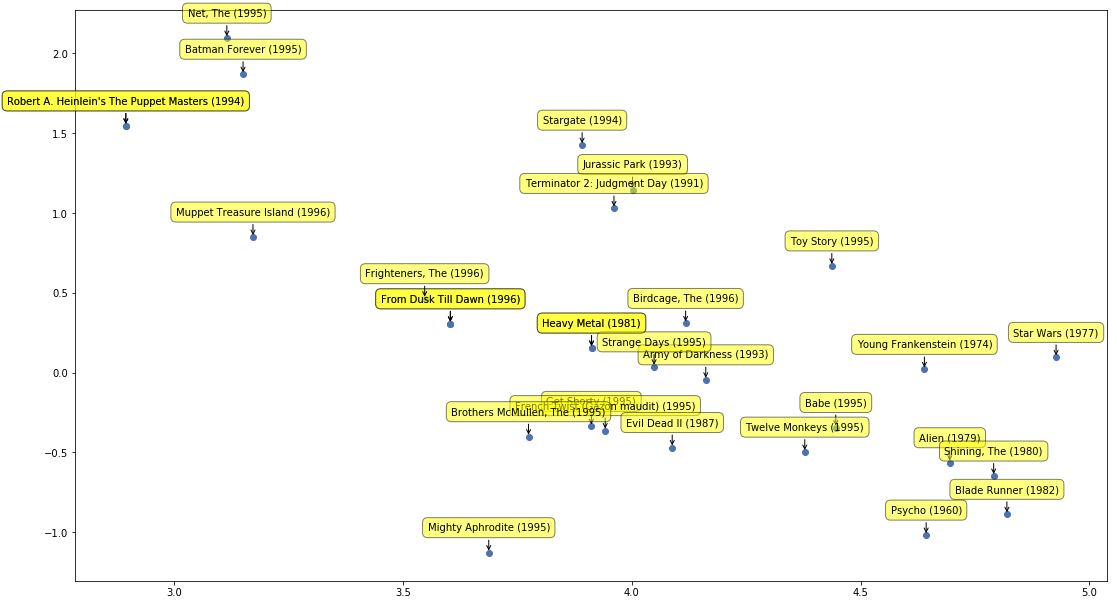

In [11]:
#===============================================================================================
# Visualize V for ten movies from the Comedy, Romance, Horror genre you selected in Section 4, Basic Visualizations
#===============================================================================================
genreList = [5] # comedies
comedies = getThreeGenres(movie_category, genreList)[0]

genreList = [11] # horrors
horrors = getThreeGenres(movie_category, genreList)[0]

genreList = [15] # romance
romances = getThreeGenres(movie_category, genreList)[0]



V0 = []
V1 = []
titles = []
for i in range(10):
    idx = comedies[i]
    V0.append(V_proj[0, idx - 1])
    V1.append(V_proj[1, idx - 1])
    titles.append(movie_ID[idx])
    
for i in range(10):
    idx = horrors[i]
    V0.append(V_proj[0, idx - 1])
    V1.append(V_proj[1, idx - 1])
    titles.append(movie_ID[idx])
    
for i in range(10):
    idx = romances[i]
    V0.append(V_proj[0, idx - 1])
    V1.append(V_proj[1, idx - 1])
    titles.append(movie_ID[idx])
    

PlotMovies(V0, V1, titles, "", showTitles=True)

